## MODEL TRAINING

In [2]:
# imdb_reviews_cls.ipynb
# train a classification model to predict the reaction of reviews
#
# author  : xiao deng
# date    : 20210612
# platform: Macbook pro 14

import os
import pickle

import nltk
import numpy as np
from rich.progress import track


# 1) NLTK init
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
eng_stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# 2) Read text files of train data
train_pos_dir = './aclImdb/train/pos'
train_neg_dir = './aclImdb/train/neg'
pos_paths = [f'{train_pos_dir}/{file}' for file in os.listdir(train_pos_dir)]
neg_paths = [f'{train_neg_dir}/{file}' for file in os.listdir(train_neg_dir)]

pos_reviews = []
neg_reviews = []

for path in pos_paths:
    with open(path) as f:
        pos_reviews.append(f.read())

for path in neg_paths:
    with open(path) as f:
        neg_reviews.append(f.read())

# 3) Text Preprocessing
# Step1: sentence seg
pos_sentences = [nltk.sent_tokenize(review) for review in track(pos_reviews, 'Sentence tokenize pos reivews ...')]
neg_sentences = [nltk.sent_tokenize(review) for review in track(neg_reviews, 'Sentence tokenize neg reivews ...')]

# Step2: word seg (apply lowercase, mark removal, digit removal, stopword removal, lemma, stemming)
word_code_map = {}
pos_map = {'J': nltk.corpus.wordnet.ADJ,
           'V': nltk.corpus.wordnet.VERB,
           'R': nltk.corpus.wordnet.ADV}
# positive reviews
pos_words = []
for sentences in track(pos_sentences, 'Word tokenize pos reivews ...'):
    review_words = []
    
    for sentence in sentences:
        words = nltk.tokenize.word_tokenize(sentence)
        words = [word.lower() for word in words if word.isalnum() and not word.isdigit() and word not in eng_stopwords]
        pos_tags = [ele[1][0] for ele in nltk.pos_tag(words)]
        pos_tags = [pos_map[tag] if tag in pos_map else nltk.corpus.wordnet.NOUN for tag in pos_tags]
        words = [lemmatizer.lemmatize(word, pos=pos_tags[i]) for i, word in enumerate(words)]
        words = [stemmer.stem(word) for word in words]
        for word in words:
            if word not in word_code_map:
                word_code_map[word] = len(word_code_map)
        review_words += words
    
    pos_words.append(review_words)

# negative reviews
neg_words = []
for sentences in track(neg_sentences, 'Word tokenize neg reivews ...'):
    review_words = []
    
    for sentence in sentences:
        words = nltk.tokenize.word_tokenize(sentence)
        words = [word.lower() for word in words if word.isalnum() and not word.isdigit() and word not in eng_stopwords]
        pos_tags = [ele[1][0] for ele in nltk.pos_tag(words)]
        pos_tags = [pos_map[tag] if tag in pos_map else nltk.corpus.wordnet.NOUN for tag in pos_tags]
        words = [lemmatizer.lemmatize(word, pos=pos_tags[i]) for i, word in enumerate(words)]
        words = [stemmer.stem(word) for word in words]
        for word in words:
            if word not in word_code_map:
                word_code_map[word] = len(word_code_map)
        review_words += words
    
    neg_words.append(review_words)

with open('word_code_map.pkl', 'wb') as f:
    pickle.dump(word_code_map, f)

# 4) Encoding
max_len = max([len(review) for review in pos_words+neg_words])
pos_x = []
for sentence in pos_words:
    sentence_encode = [word_code_map[word] for word in sentence]
    sentence_encode = np.pad(sentence_encode, (0, max_len-len(sentence_encode)), mode='constant')
    pos_x.append(sentence_encode)
pos_y = [True] * len(pos_x)

neg_x = []
for sentence in neg_words:
    sentence_encode = [word_code_map[word] for word in sentence]
    sentence_encode = np.pad(sentence_encode, (0, max_len-len(sentence_encode)), mode='constant')
    neg_x.append(sentence_encode)
neg_y = [False] * len(neg_x)

[nltk_data] Downloading package punkt to /Users/xiao_deng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xiao_deng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/xiao_deng/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiao_deng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/xiao_deng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Output()

Output()

Output()

Output()

In [6]:
import random

from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout, Conv1D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# 5) Split training & validation set
seed = 0
random.Random(seed).shuffle(pos_x)
random.Random(seed).shuffle(neg_x)

train_ratio = 0.8
idx_p = int(len(pos_x) * train_ratio)
idx_n = int(len(neg_x) * train_ratio)
train_x = pos_x[:idx_p] + neg_x[:idx_n]
train_y = pos_y[:idx_p] + neg_y[:idx_n]
valid_x = pos_x[idx_p:] + neg_x[idx_n:]
valid_y = pos_y[idx_p:] + neg_y[idx_n:]

seed = 1
random.Random(seed).shuffle(train_x)
random.Random(seed).shuffle(train_y)
random.Random(seed).shuffle(valid_x)
random.Random(seed).shuffle(valid_y)

train_x = np.array(train_x)
train_y = np.array(train_y)
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

print(f'train_x shape: {train_x.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'valid_x shape: {valid_x.shape}')
print(f'valid_y shape: {valid_y.shape}')

# 6) Build CNN model with word2vec in TF (I used a similar model to classify EMR in my master thesis)
# ref: extension://bfdogplmndidlpjfhoijckpakkdjkkil/pdf/viewer.html?file=https%3A%2F%2Farxiv.org%2Fpdf%2F1408.5882.pdf
embedding_dim = 128
model = Sequential([
    Embedding(len(word_code_map), embedding_dim, input_length=max_len),
    Dropout(0.5),
    Conv1D(64, 5, padding='same', activation='relu', strides=1),
    GlobalMaxPooling1D(),
    Dense(32, activation='linear'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

init_lr = 1e-4
model.compile(optimizer=Adam(learning_rate=init_lr),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['Accuracy'])

model.summary()

# 7) Fit the training data
callbacks = [TensorBoard(log_dir="logs"),
             EarlyStopping(patience=7),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=init_lr/100)]

model.fit(
    train_x,
    train_y,
    batch_size=32,
    validation_data=(valid_x, valid_y),
    epochs=60,
    callbacks=callbacks
)

model.save('imdb_cls_model.h5')

train_x shape: (20000, 1486)
train_y shape: (20000,)
valid_x shape: (5000, 1486)
valid_y shape: (5000,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1486, 128)         6250752   
                                                                 
 dropout (Dropout)           (None, 1486, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, 1486, 64)          41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 batch_normaliza

2022-06-13 18:17:45.783779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.7377 - Accuracy: 0.5212

2022-06-13 18:18:53.424627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 70s 106ms/step - loss: 0.7377 - Accuracy: 0.5212 - val_loss: 0.7963 - val_Accuracy: 0.5042 - lr: 1.0000e-04
Epoch 2/60
625/625 [==============================] - 63s 101ms/step - loss: 0.6486 - Accuracy: 0.6177 - val_loss: 0.7735 - val_Accuracy: 0.5574 - lr: 1.0000e-04
Epoch 3/60
625/625 [==============================] - 62s 99ms/step - loss: 0.5696 - Accuracy: 0.7036 - val_loss: 0.5795 - val_Accuracy: 0.7050 - lr: 1.0000e-04
Epoch 4/60
625/625 [==============================] - 60s 96ms/step - loss: 0.4933 - Accuracy: 0.7629 - val_loss: 0.4854 - val_Accuracy: 0.7666 - lr: 1.0000e-04
Epoch 5/60
625/625 [==============================] - 63s 101ms/step - loss: 0.4167 - Accuracy: 0.8115 - val_loss: 0.4602 - val_Accuracy: 0.7908 - lr: 1.0000e-04
Epoch 6/60
625/625 [==============================] - 65s 103ms/step - loss: 0.3633 - Accuracy: 0.8471 - val_loss: 0.4089 - val_Accuracy: 0.8174 - lr: 1.0000e-04
Epoch 7/60
625/625 [=====================

## MODEL EVALUATION

In [5]:
import os
import pickle

import nltk
import numpy as np
from rich.progress import track


# 1) NLTK init
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
eng_stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# 2) Read text files of train data
test_pos_dir = './aclImdb/test/pos'
test_neg_dir = './aclImdb/test/neg'
pos_paths = [f'{test_pos_dir}/{file}' for file in os.listdir(test_pos_dir)]
neg_paths = [f'{test_neg_dir}/{file}' for file in os.listdir(test_neg_dir)]

pos_reviews = []
neg_reviews = []

for path in pos_paths:
    with open(path) as f:
        pos_reviews.append(f.read())

for path in neg_paths:
    with open(path) as f:
        neg_reviews.append(f.read())

# 3) Text Preprocessing
# Step1: sentence seg
pos_sentences = [nltk.sent_tokenize(review) for review in track(pos_reviews, 'Sentence tokenize pos reivews ...')]
neg_sentences = [nltk.sent_tokenize(review) for review in track(neg_reviews, 'Sentence tokenize neg reivews ...')]

# Step2: word seg (apply lowercase, mark removal, digit removal, stopword removal, lemma, stemming)
with open('word_code_map.pkl', 'rb') as f:
    word_code_map = pickle.load(f)
pos_map = {'J': nltk.corpus.wordnet.ADJ,
           'V': nltk.corpus.wordnet.VERB,
           'R': nltk.corpus.wordnet.ADV}
# positive reviews
pos_words = []
for sentences in track(pos_sentences, 'Word tokenize pos reivews ...'):
    review_words = []
    
    for sentence in sentences:
        words = nltk.tokenize.word_tokenize(sentence)
        words = [word.lower() for word in words if word.isalnum() and not word.isdigit() and word not in eng_stopwords]
        pos_tags = [ele[1][0] for ele in nltk.pos_tag(words)]
        pos_tags = [pos_map[tag] if tag in pos_map else nltk.corpus.wordnet.NOUN for tag in pos_tags]
        words = [lemmatizer.lemmatize(word, pos=pos_tags[i]) for i, word in enumerate(words)]
        words = [stemmer.stem(word) for word in words]
        review_words += words
    
    pos_words.append(review_words)

# negative reviews
neg_words = []
for sentences in track(neg_sentences, 'Word tokenize neg reivews ...'):
    review_words = []
    
    for sentence in sentences:
        words = nltk.tokenize.word_tokenize(sentence)
        words = [word.lower() for word in words if word.isalnum() and not word.isdigit() and word not in eng_stopwords]
        pos_tags = [ele[1][0] for ele in nltk.pos_tag(words)]
        pos_tags = [pos_map[tag] if tag in pos_map else nltk.corpus.wordnet.NOUN for tag in pos_tags]
        words = [lemmatizer.lemmatize(word, pos=pos_tags[i]) for i, word in enumerate(words)]
        words = [stemmer.stem(word) for word in words]
        review_words += words
    
    neg_words.append(review_words)

# 4) Encoding
max_len = 1486 # max_len of training set
pos_x = []
for sentence in pos_words:
    sentence_encode = [word_code_map[word] for word in sentence if word in word_code_map]
    if len(sentence_encode) <= max_len:
        sentence_encode = np.pad(sentence_encode, (0, max_len-len(sentence_encode)), mode='constant')
    else:
        sentence_encode = sentence_encode[:max_len]
    pos_x.append(sentence_encode)
pos_y = [True] * len(pos_x)

neg_x = []
for sentence in neg_words:
    sentence_encode = [word_code_map[word] for word in sentence if word in word_code_map]
    if len(sentence_encode) <= max_len:
        sentence_encode = np.pad(sentence_encode, (0, max_len-len(sentence_encode)), mode='constant')
    else:
        sentence_encode = sentence_encode[:max_len]
    neg_x.append(sentence_encode)
neg_y = [False] * len(neg_x)

[nltk_data] Downloading package punkt to /Users/xiao_deng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xiao_deng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/xiao_deng/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiao_deng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/xiao_deng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Output()

Output()

Output()

Output()

test_x shape: (25000, 1486)
test_y shape: (25000,)
Metal device set to: Apple M1 Pro


2022-06-13 19:45:13.666996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-13 19:45:13.667118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 10/782 [..............................] - ETA: 4s  

2022-06-13 19:45:13.949010: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-13 19:45:13.994430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 3s 4ms/step
test_pred shape: (25000,)


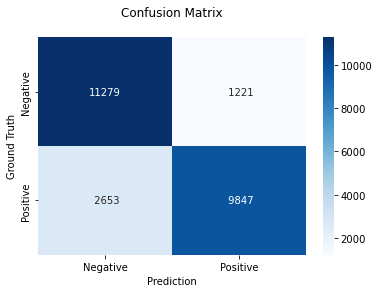

              precision    recall  f1-score   support

    Negative       0.81      0.90      0.85     12500
    Positive       0.89      0.79      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.84     25000
weighted avg       0.85      0.85      0.84     25000



In [6]:
import seaborn
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix


# 5) Create testing set
test_x = pos_x + neg_x
test_y = pos_y + neg_y
test_x = np.array(test_x)
test_y = np.array(test_y)

print(f'test_x shape: {test_x.shape}')
print(f'test_y shape: {test_y.shape}')

# 6) Load pre-trained model and predict testing reviews
model = load_model('imdb_cls_model.h5')
test_pred = [True if pred >= 0.5 else False for pred in model.predict(test_x)]
test_pred = np.array(test_pred)

print(f'test_pred shape: {test_pred.shape}')

# 7) Draw confusion matrix & calculate classification report
labels = ['Negative', 'Positive']

conf_matrix = confusion_matrix(test_y, test_pred)
ax = seaborn.heatmap(conf_matrix, annot=True, fmt='5', cmap='Blues')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print(classification_report(test_y, test_pred, target_names=labels))